<a href="https://colab.research.google.com/github/dksifoua/Optical-Character-Recognition/blob/main/Optical%20Character%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Oct 19 15:06:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [8]:
%%time
!mkdir -p ./data

!wget --no-check-certificate \
    http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz \
    -O ./data/EnglishImg.tgz
!tar zxf ./data/EnglishImg.tgz -C ./data/
!rm ./data/EnglishImg.tgz

!wget --no-check-certificate \
    http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz \
    -O ./data/EnglishHnd.tgz
!tar zxf ./data/EnglishHnd.tgz -C ./data/
!rm ./data/EnglishHnd.tgz

!wget --no-check-certificate \
    http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz \
    -O ./data/EnglishFnt.tgz
!tar zxf ./data/EnglishFnt.tgz -C ./data/
!rm ./data/EnglishFnt.tgz

!wget --no-check-certificate \
    http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/Lists.tgz \
    -O ./data/Lists.tgz
!tar zxf ./data/Lists.tgz -C ./data/
!rm ./data/Lists.tgz

--2020-10-19 15:24:06--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133975105 (128M) [application/x-gzip]
Saving to: ‘./data/EnglishImg.tgz’

./data/EnglishImg.t 100%[===================>] 127.77M  31.4MB/s    in 4.7s    

2020-10-19 15:24:10 (27.4 MB/s) - ‘./data/EnglishImg.tgz’ saved [133975105/133975105]

--2020-10-19 15:24:14--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13596287 (13M) [application/x-gzip]
Saving to: ‘./data/EnglishHnd.tgz’

./data/EnglishHnd.t 100%[===================>]  12.97M  13.0MB/s    in 1.0s    

2020-

In [108]:
LABELS = [f'{c}' for c in range(10)] + [chr(c) for c in range(ord('A'), ord('Z') + 1)] + [chr(c) for c in range(ord('a'), ord('z') + 1)]

In [109]:
def load(path):
    content = tf.io.read_file(path)
    image = tf.image.decode_png(content, channels=1) # Load as gray scale
    image = tf.cast(image, tf.float32)
    label = tf.strings.split(path, sep='/')[-2]
    label = tf.strings.substr(label, 7, 3)
    label = tf.strings.to_number(label, out_type=tf.int64)
    return image, label

In [110]:
data = tf.data.Dataset.list_files('./data/English/Fnt/*/*.png').map(load, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [138]:
for image, label in data.batch(28):
    print(image.shape)
    # plt.imshow(image.numpy().squeeze())
    # plt.title(LABELS[label.numpy()[0] - 1])
    # plt.show()
    break

(28, 128, 128, 1)


In [140]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu, input_shape=(128, 128, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(LABELS))
])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 32, 64)      

In [137]:
history = model.fit(data, batch_size=128, epochs=10, callbacks=[callback])

Epoch 1/10


ValueError: ignored

In [5]:
!wget https://raw.githubusercontent.com/abhinandanarya06/OCR/master/sample_test_image/1.jpg

--2020-10-19 14:46:36--  https://raw.githubusercontent.com/abhinandanarya06/OCR/master/sample_test_image/1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2325637 (2.2M) [image/jpeg]
Saving to: ‘1.jpg’

1.jpg               100%[===================>]   2.22M  10.2MB/s    in 0.2s    

2020-10-19 14:46:37 (10.2 MB/s) - ‘1.jpg’ saved [2325637/2325637]



In [7]:
import cv2
import matplotlib.pyplot as plt


(2422, 1656, 3)


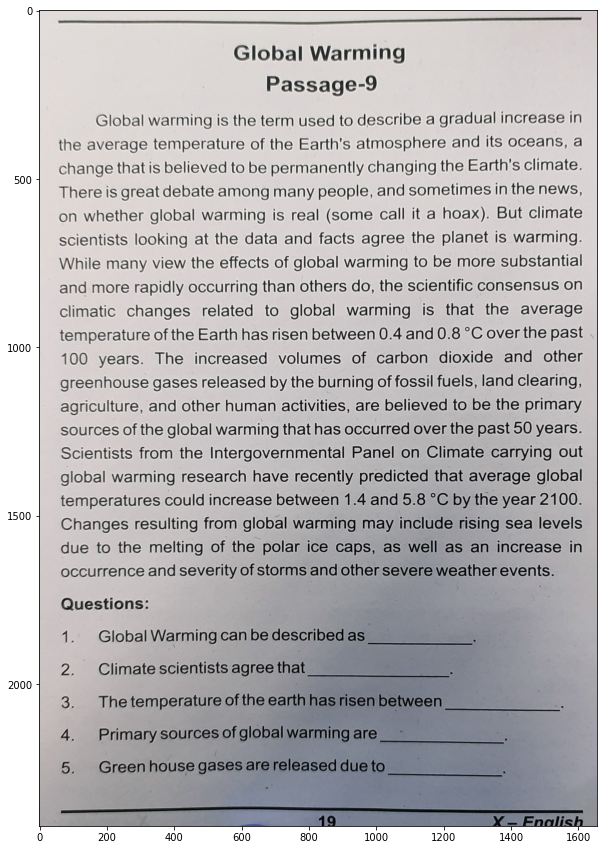

In [25]:
image = cv2.imread('./1.jpg')
print(image.shape)
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()

(2422, 1656)


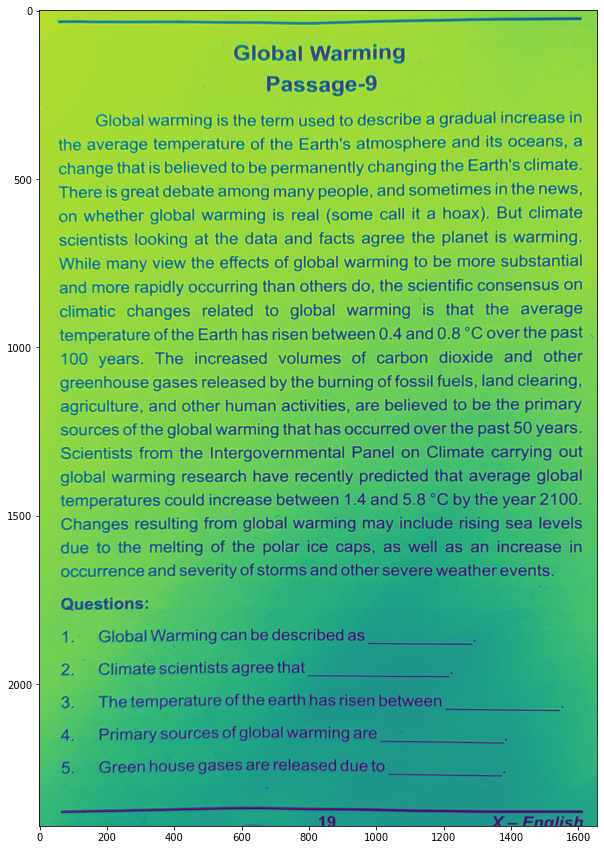

In [26]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()

(2422, 1656)


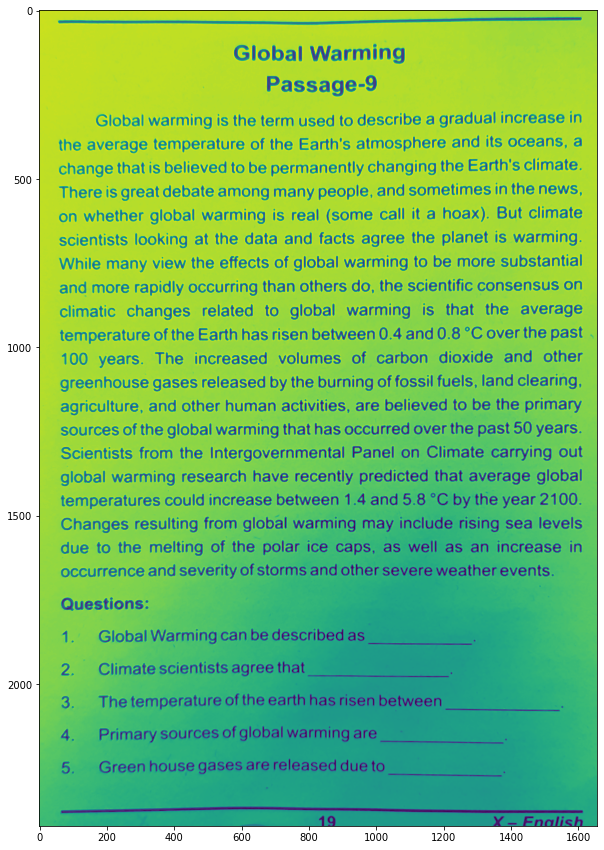

In [27]:
image = cv2.medianBlur(image, 5)
print(image.shape)
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()

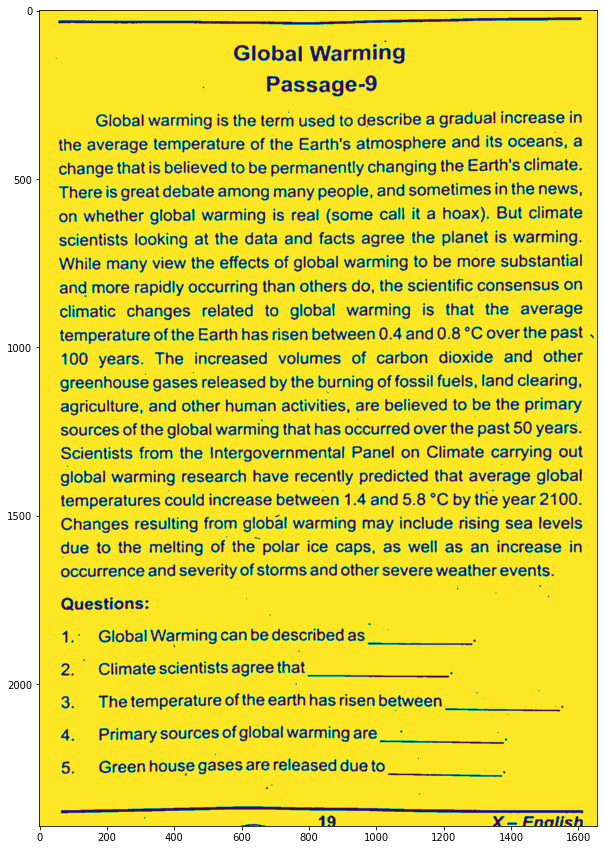

In [28]:
image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 41, 10)
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()

In [30]:
contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

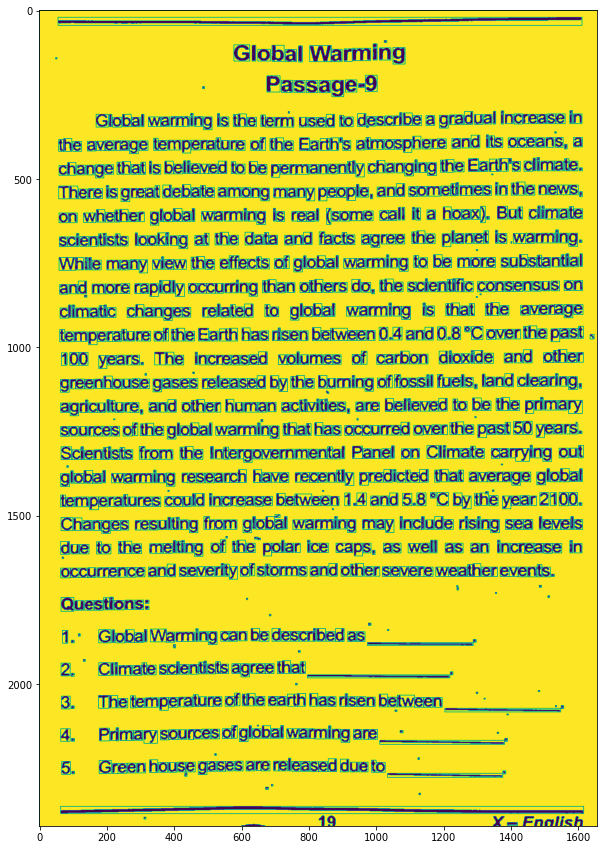

In [31]:
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.show()